In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import random
import numpy as np
from tqdm import tqdm

In [3]:
calib_share = 0.5
delta = 0.1

nbr_lcp_trajs = 100

nbr_trials = 100

In [4]:
# Load data dictionary
with open("outputs/pedestrians.pkl", "rb") as f:
    data_dict = pickle.load(f)

In [5]:
pred_vals = data_dict["pred"]
true_vals = data_dict["actual"]

In [6]:
from uq.cfrnn import CFRNN
from uq.copulaCPTS import copulaCPTS
from uq.complementary import LCPCP

In [7]:
# Split data into calibration and test sets
nbr_trajs = pred_vals.shape[0]
nbr_timesteps = pred_vals.shape[1]
nbr_dims = pred_vals.shape[2]

radii_cp = []
radii_lcp = []
radii_copula = []
radii_cp_correlated = []

cov_per_timestep_cp = []
cov_per_traj_cp = []
cov_corr_per_timestep_cp = []
cov_corr_per_traj_cp = []
cov_lcp_per_timestep = []
cov_lcp_per_traj = []
cov_copula_per_timestep = []
cov_copula_per_traj = []

for trial in tqdm(range(nbr_trials)):
    random_state = np.random.RandomState(trial ** 3)
    calib_idxs = random_state.choice(range(nbr_trajs), int(calib_share * nbr_trajs), replace=False)
    test_idxs = list(set(range(nbr_trajs)) - set(calib_idxs))
    cali_y = true_vals[calib_idxs]
    cali_pred = pred_vals[calib_idxs]
    test_y = true_vals[test_idxs]
    test_pred = pred_vals[test_idxs]

    cp_vanilla = CFRNN(None, cali_y, cali_pred=cali_pred)
    cp_vanilla.calibrate()
    radius_cp = cp_vanilla.get_radius(epsilon=delta)
    radii_cp.append(radius_cp)
    radius_cp_corr = cp_vanilla.get_radius(epsilon=delta * cali_y.shape[-2])
    radii_cp_correlated.append(radius_cp_corr)

    cp_lcp = LCPCP(None, cali_y, cali_pred=cali_pred)
    trajs_idxs = random_state.choice(range(cali_y.shape[0]), nbr_lcp_trajs, replace=False)
    cp_lcp.cali1_y = cali_y[trajs_idxs]
    cp_lcp.cali2_y = cali_y[~trajs_idxs]
    cp_lcp.cali1_pred = cali_pred[trajs_idxs]
    cp_lcp.cali2_pred = cali_pred[~trajs_idxs]
    radius_lcp = cp_lcp.get_radii(delta=delta)
    radii_lcp.append(radius_lcp)
    cp_copula = copulaCPTS(None, cali_y, cali_pred=cali_pred)
    cp_copula.split_cali(cali_x=cali_y.copy(), cali_y=cali_y, split=0.9, random_state=random_state)
    cp_copula.calibrate()
    radius_copula = cp_copula.get_radius(epsilon=delta)
    radii_copula.append(radius_copula)

    # Evaluate on the test set
    scores = np.linalg.norm((test_pred-test_y), axis = -1)
    coverage_cp = scores <= radius_cp
    cov_per_timestep_cp.append(np.mean(coverage_cp, axis=0))
    cov_per_traj_cp.append(np.mean(np.all(coverage_cp, axis=1)))
    coverage_cp_correlated = scores <= radius_cp_corr
    cov_corr_per_timestep_cp.append(np.mean(coverage_cp_correlated, axis=0))
    cov_corr_per_traj_cp.append(np.mean(np.all(coverage_cp_correlated, axis=1)))
    cov_lcp_correlated = scores <= radius_lcp
    cov_lcp_per_timestep.append(np.mean(cov_lcp_correlated, axis=0))
    cov_lcp_per_traj.append(np.mean(np.all(cov_lcp_correlated, axis=1)))
    cov_copula = scores <= radius_copula
    cov_copula_per_timestep.append(np.mean(cov_copula, axis=0))
    cov_copula_per_traj.append(np.mean(np.all(cov_copula, axis=1)))

radii_cp = np.array(radii_cp)
radii_cp_correlated = np.array(radii_cp_correlated)
radii_lcp = np.array(radii_lcp)
radii_copula = np.array(radii_copula)

cov_per_timestep_cp = np.array(cov_per_timestep_cp)
cov_per_traj_cp = np.array(cov_per_traj_cp)
cov_corr_per_timestep_cp = np.array(cov_corr_per_timestep_cp)
cov_corr_per_traj_cp = np.array(cov_corr_per_traj_cp)
cov_lcp_per_timestep = np.array(cov_lcp_per_timestep)
cov_lcp_per_traj = np.array(cov_lcp_per_traj)
cov_copula_per_timestep = np.array(cov_copula_per_timestep)
cov_copula_per_traj = np.array(cov_copula_per_traj)


100%|██████████| 2/2 [02:27<00:00, 73.72s/it]


In [8]:
import matplotlib
# Large fonts and latex
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rc('text', usetex=True)

In [9]:
import matplotlib.pyplot as plt

In [10]:
import seaborn as sns
import pandas as pd

Text(0, 0.5, 'Radius')

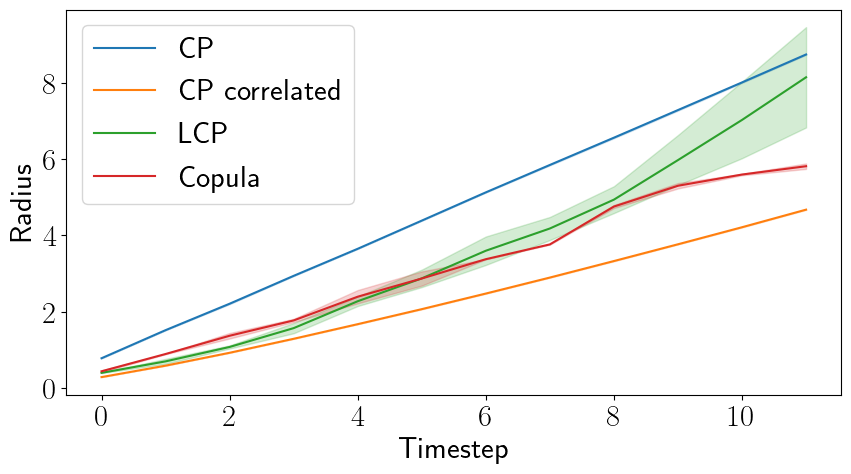

In [11]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=pd.DataFrame(radii_cp).melt(), x="variable", y="value", label="CP")
sns.lineplot(data=pd.DataFrame(radii_cp_correlated).melt(), x="variable", y="value", label="CP correlated")
sns.lineplot(data=pd.DataFrame(radii_lcp).melt(), x="variable", y="value", label="LCP")
sns.lineplot(data=pd.DataFrame(radii_copula).melt(), x="variable", y="value", label="Copula")
plt.legend()
plt.xlabel("Timestep")
plt.ylabel("Radius")

(0.0, 11.0)

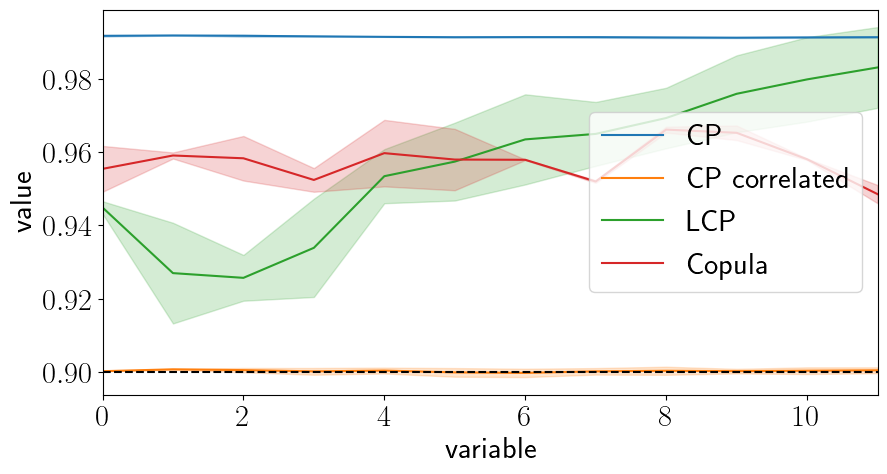

In [12]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=pd.DataFrame(cov_per_timestep_cp).melt(), x="variable", y="value", label="CP")
sns.lineplot(data=pd.DataFrame(cov_corr_per_timestep_cp).melt(), x="variable", y="value", label="CP correlated")
sns.lineplot(data=pd.DataFrame(cov_lcp_per_timestep).melt(), x="variable", y="value", label="LCP")
sns.lineplot(data=pd.DataFrame(cov_copula_per_timestep).melt(), x="variable", y="value", label="Copula")
plt.plot(np.arange(0, 20), np.ones(20) * 0.9, linestyle="--", color="black")
plt.xlim((0, 11))

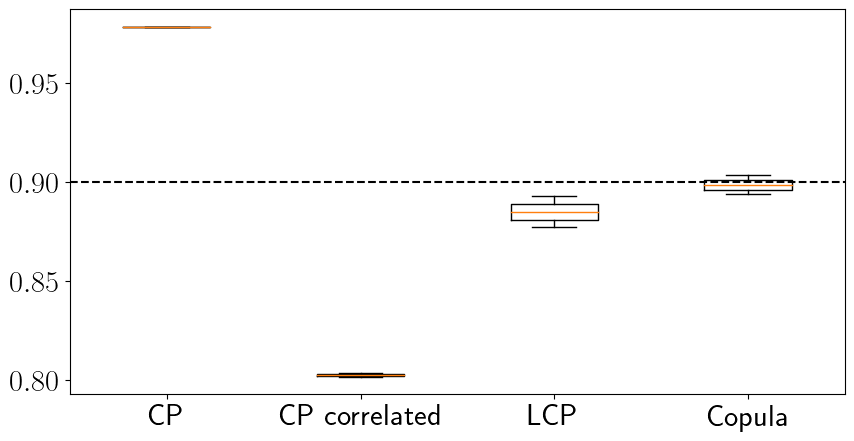

In [13]:
plt.figure(figsize=(10, 5))
plt.boxplot([cov_per_traj_cp, cov_corr_per_traj_cp, cov_lcp_per_traj, cov_copula_per_traj], labels=["CP", "CP correlated", "LCP", "Copula"])
plt.plot(np.arange(0.5, 5.5), np.ones(5) * 0.9, linestyle="--", color="black")